# Simulation - Projet

## Importation des modules nécessaires


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
import math

## Lecture du fichier d'entrée

In [9]:
def e_numbers():
    with open("exp.txt", "r") as e:
        for line in e:
            line = line.strip()
            if "." in line:
                line = line.split(".")[1]
            for c in line:
                yield int(c)

e_numbers = np.array(list(e_numbers()))
print(f'Les 2.000.000 premières décimales d\' exp :\n {e_numbers}')

Les 2.000.000 premières décimales d' exp :
 [7 1 8 ... 0 2 3]


## Compter effectif

In [10]:
def count_number(data):
    values, counts = np.unique(data, return_counts=True)
    return values, counts

e_labels, e_counts = count_number(e_numbers)
print(f'Les valeurs apparaissant dans les décimales d\' exp : \n {e_labels}')
print(f'Leur fréquences d\'apparition : \n {e_counts}')

Les valeurs apparaissant dans les décimales d' exp : 
 [0 1 2 3 4 5 6 7 8 9]
Leur fréquences d'apparition : 
 [199093 200171 199471 200361 199923 200285 200395 199789 200098 200414]


## Construire histogramme


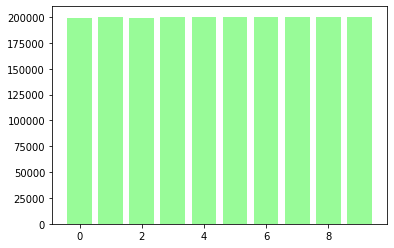

In [11]:
def construct_hist(labels, counts):
    fig, ax = plt.subplots()
    ax.bar(labels, counts, color='palegreen')
    plt.show()

construct_hist(e_labels, e_counts)

## Test du Chi-Carré

In [12]:
def chi_squared(counts):
    pi = 1 / len(counts)
    N = sum(counts)
    kr = np.sum(((counts-(N*pi))/(math.sqrt(N*pi)))**2)
    critical = stat.chi2.ppf(q=0.95, df=9)
    return kr <= critical, kr, critical

print(f'Le résultat de notre test du Chi-Carré est : \n {chi_squared(e_counts)}')

Le résultat de notre test du Chi-Carré est : 
 (True, 8.65376, 16.918977604620448)


## Test de Kolmogorov-Smirnov

In [13]:
def kolmogorov_smirnov(labels, counts):
    assert len(labels) == len(counts)
    pi = 1 / len(counts)
    N = np.sum(counts)
    real_repartition = np.cumsum(counts, axis=0)/N
    th_repartition = np.cumsum(np.ones(len(labels))*pi)
    maximum = np.max(np.abs(real_repartition-th_repartition))
    critical = 1.358/math.sqrt(N/len(labels))
    return maximum < critical, maximum, critical

print(kolmogorov_smirnov(e_labels, e_counts))

(True, 0.0006325000000000358, 0.0030365803134447147)


## Test du gap

In [14]:
def poker_test(data, labels, counts):
    number_lists = len(data)/4
    print(number_lists)
    lists = np.split(data, number_lists)
    all_diff = 0
    one_pair = 0
    two_pair = 0
    triplet = 0
    quadr = 0
    for li in lists:
        values, counts = np.unique(li, return_counts=True)
        if len(counts) == 4:
            all_diff += 1
        elif len(counts) == 3:
            one_pair += 1
        elif len(counts) == 2:
            if 3 in counts:
                triplet += 1
            else:
                two_pair += 1
        else:
            quadr += 1
    print(f'all_diff {all_diff} \n'
          f'one_pair {one_pair} \n'
          f'two_pair {two_pair} \n'
          f'triplet {triplet} \n'
          f'quadr {quadr}')




print(f'Test du Poker {poker_test(e_numbers, e_labels, e_counts)}')

500000.0
all_diff 251785 
one_pair 216258 
two_pair 13413 
triplet 18050 
quadr 494
Test du Poker None
